In [ ]:
# upload the following files:
# files from 1st march to 29th march
# sim files from 25th to 29th march which are in new_model files

In [1]:
import pandas as pd
import os

# Define the directory where your CSV files are stored
data_dir = "/content/"  # Adjust if needed

# Create a list to hold data from each day
data_frames = []

# Updated list of filenames
dates = ["2025-03-01", "2025-03-02", "2025-03-03", "2025-03-04", "2025-03-05",
         "2025-03-06", "2025-03-07", "2025-03-08", "2025-03-09", "2025-03-10",
         "2025-03-11", "2025-03-12", "2025-03-13", "2025-03-14", "2025-03-15",
         "2025-03-16", "2025-03-17", "2025-03-18", "2025-03-19", "2025-03-20",
         "2025-03-21", "2025-03-22", "2025-03-23", "2025-03-24", "2025-03-25_sim",
         "2025-03-26_sim", "2025-03-27_sim", "2025-03-28_sim", "2025-03-29_sim"]

# Loop through the updated date strings
for date_str in dates:
    file_path = os.path.join(data_dir, f"{date_str}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['date_time'] = pd.to_datetime(df['date_time'])
        data_frames.append(df)
    else:
        print(f"File not found: {file_path}")

# Combine all dataframes
combined_df = pd.concat(data_frames, ignore_index=True)

# Sort by datetime to ensure it's in order
combined_df = combined_df.sort_values('date_time').reset_index(drop=True)

# Save the combined data to CSV
combined_df.to_csv("/content/combined_march1_29.csv", index=False)

# Show a preview of the first few rows of the combined dataset
combined_df.head()


,date_time,load
0,2025-03-01 00:00:00,11432.431510
1,2025-03-01 00:15:00,11842.011393
2,2025-03-01 00:30:00,11806.792383
3,2025-03-01 00:45:00,11722.334831
4,2025-03-01 01:00:00,11472.657487


In [ ]:
import numpy as np

# Load the combined dataset (ensure it's loaded from previous steps)
df = pd.read_csv("/content/combined_march1_29.csv")
df['date_time'] = pd.to_datetime(df['date_time'])

# Time-based features
df['hour'] = df['date_time'].dt.hour
df['minute'] = df['date_time'].dt.minute
df['day_of_week'] = df['date_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Day progress (percentage of the day passed)
df['day_progress'] = (df['hour'] * 60 + df['minute']) / (24 * 60)

# Day sine and cosine to capture daily cycles
df['day_sine'] = np.sin(2 * np.pi * df['hour'] / 24)
df['day_cosine'] = np.cos(2 * np.pi * df['hour'] / 24)

# Lag features (previous time steps)
df['lag_1'] = df['load'].shift(1)
df['lag_2'] = df['load'].shift(2)
df['lag_3'] = df['load'].shift(3)
df['lag_4'] = df['load'].shift(4)
df['lag_96'] = df['load'].shift(96)  # 24 hours ago

# Track the number of rows before dropping NaNs
initial_len = len(df)

# Drop rows with NaN values (due to lag features)
df = df.dropna().reset_index(drop=True)

# Track the number of rows after dropping NaNs
final_len = len(df)

# Number of dropped rows
dropped_rows = initial_len - final_len

# Print the number of dropped rows and the number of remaining data points
print(f"Rows before dropping NaNs: {initial_len}")
print(f"Rows after dropping NaNs: {final_len}")
print(f"Number of dropped rows: {dropped_rows}")

# Optionally: Rolling features (e.g., rolling mean over the last 4 time steps)
df['rolling_mean_4'] = df['load'].rolling(window=4).mean()
df['rolling_std_4'] = df['load'].rolling(window=4).std()

# Save the feature-enhanced dataset
df.to_csv("/content/features_march1_29.csv", index=False)

# Show the first few rows to ensure everything is extracted correctly
df.head()


Rows before dropping NaNs: 2784
Rows after dropping NaNs: 2688
Number of dropped rows: 96


,date_time,load,hour,minute,day_of_week,is_weekend,day_progress,day_sine,day_cosine,lag_1,lag_2,lag_3,lag_4,lag_96,rolling_mean_4,rolling_std_4
0,2025-03-02 00:00:00,11616.454215,0,0,6,1,0.000000,0.000000,1.000000,11731.084766,11889.677409,12053.143750,12146.105794,11432.431510,NaN,NaN
1,2025-03-02 00:15:00,12109.445972,0,15,6,1,0.010417,0.000000,1.000000,11616.454215,11731.084766,11889.677409,12053.143750,11842.011393,NaN,NaN
2,2025-03-02 00:30:00,12023.783732,0,30,6,1,0.020833,0.000000,1.000000,12109.445972,11616.454215,11731.084766,11889.677409,11806.792383,NaN,NaN
3,2025-03-02 00:45:00,11981.087598,0,45,6,1,0.031250,0.000000,1.000000,12023.783732,12109.445972,11616.454215,11731.084766,11722.334831,11932.692879,217.476543
4,2025-03-02 01:00:00,11796.294238,1,0,6,1,0.041667,0.258819,0.965926,11981.087598,12023.783732,12109.445972,11616.454215,11472.657487,11977.652885,132.161806


In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load the combined dataset (after feature extraction)
df = pd.read_csv("/content/features_march1_29.csv")
df['date_time'] = pd.to_datetime(df['date_time'])

# Set 'date_time' as index for easier slicing (optional)
df.set_index('date_time', inplace=True)

# Define the features (X) and target (y)
X = df.drop(columns=['load'])  # Features (everything except 'load')
y = df['load']  # Target variable (load)

# Scale the features and target
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled features back to DataFrame for easy manipulation
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=df.index)
y_scaled = pd.DataFrame(y_scaled, columns=['load'], index=df.index)

# Split the data into training (March 1 to 24) and validation (March 25 to 29)
train_X = X_scaled[:'2025-03-24']
train_y = y_scaled[:'2025-03-24']
val_X = X_scaled['2025-03-25':]
val_y = y_scaled['2025-03-25':]

# Save the scaled data to files
train_X.to_csv("/content/train_X_scaled.csv", index=True)
train_y.to_csv("/content/train_y_scaled.csv", index=True)
val_X.to_csv("/content/val_X_scaled.csv", index=True)
val_y.to_csv("/content/val_y_scaled.csv", index=True)

# Check the shape of the data (confirm split)
print("Training data shape (X, y):", train_X.shape, train_y.shape)
print("Validation data shape (X, y):", val_X.shape, val_y.shape)


Training data shape (X, y): (2208, 14) (2208, 1)
Validation data shape (X, y): (480, 14) (480, 1)


In [4]:
# Check for NaN values in X_train, Y_train, X_val, and Y_val

# Function to check and clean data
def check_and_clean_data(X, Y, dataset_name):
    # Check for NaN values in X and Y
    nan_X = X[X.isna().any(axis=1)]
    nan_Y = Y[Y.isna()]

    # Print the data points with NaN values
    if not nan_X.empty:
        print(f"NaN values found in {dataset_name} features (X):")
        print(nan_X)
    if not nan_Y.empty:
        print(f"NaN values found in {dataset_name} target (Y):")
        print(nan_Y)

    # Remove rows with NaN values from X and Y
    X_clean = X.dropna()
    Y_clean = Y.loc[X_clean.index]  # Ensure corresponding rows from Y are removed

    # Print the amount of data points removed
    removed_rows_X = len(X) - len(X_clean)
    removed_rows_Y = len(Y) - len(Y_clean)

    print(f"\nAmount of data points removed in {dataset_name} due to NaN:")
    print(f"Rows removed from features: {removed_rows_X}")
    print(f"Rows removed from target: {removed_rows_Y}")

    # Save the cleaned data back to the same files (optional)
    X_clean.to_csv(f"/content/{dataset_name}_X_clean.csv", index=False)
    Y_clean.to_csv(f"/content/{dataset_name}_Y_clean.csv", index=False)

    # Return the cleaned data
    return X_clean, Y_clean

# Check and clean X_train, Y_train, X_val, Y_val
X_train_clean, Y_train_clean = check_and_clean_data(train_X, train_y, "train")
X_val_clean, Y_val_clean = check_and_clean_data(val_X, val_y, "val")

# Print the sizes of cleaned datasets
print("\nSizes of cleaned datasets:")
print(f"Cleaned training data shape (X, Y): {X_train_clean.shape}, {Y_train_clean.shape}")
print(f"Cleaned validation data shape (X, Y): {X_val_clean.shape}, {Y_val_clean.shape}")


NaN values found in train features (X):
                     hour    minute  day_of_week  is_weekend  day_progress  \
date_time                                                                    
2025-03-02 00:00:00   0.0  0.000000          1.0         1.0      0.000000   
2025-03-02 00:15:00   0.0  0.333333          1.0         1.0      0.010526   
2025-03-02 00:30:00   0.0  0.666667          1.0         1.0      0.021053   

                     day_sine  day_cosine     lag_1     lag_2     lag_3  \
date_time                                                                 
2025-03-02 00:00:00       0.5         1.0  0.231972  0.250280  0.269151   
2025-03-02 00:15:00       0.5         1.0  0.218738  0.231972  0.250280   
2025-03-02 00:30:00       0.5         1.0  0.275651  0.218738  0.231972   

                        lag_4    lag_96  rolling_mean_4  rolling_std_4  
date_time                                                               
2025-03-02 00:00:00  0.279883  0.197494        

In [5]:
import pandas as pd

# Load the cleaned data from the CSV files
train_X_clean = pd.read_csv('/content/train_X_clean.csv')
train_y_clean = pd.read_csv('/content/train_Y_clean.csv')
val_X_clean = pd.read_csv('/content/val_X_clean.csv')
val_y_clean = pd.read_csv('/content/val_Y_clean.csv')

# Check the data shapes to ensure everything loaded correctly
print(f"Loaded training data shape (X, Y): {train_X_clean.shape}, {train_y_clean.shape}")
print(f"Loaded validation data shape (X, Y): {val_X_clean.shape}, {val_y_clean.shape}")


Loaded training data shape (X, Y): (2205, 14), (2205, 1)
Loaded validation data shape (X, Y): (480, 14), (480, 1)


In [6]:
# Reshape the data for LSTM: [samples, time steps, features]
train_X_reshaped = train_X_clean.values.reshape((train_X_clean.shape[0], 1, train_X_clean.shape[1]))
val_X_reshaped = val_X_clean.values.reshape((val_X_clean.shape[0], 1, val_X_clean.shape[1]))

# Check the reshaped data shapes
print(f"Reshaped training data shape: {train_X_reshaped.shape}")
print(f"Reshaped validation data shape: {val_X_reshaped.shape}")


Reshaped training data shape: (2205, 1, 14)
Reshaped validation data shape: (480, 1, 14)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Build the LSTM model with enhanced features
model = Sequential()

# Add LSTM layer with L2 regularization
model.add(LSTM(units=40, return_sequences=False, input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2]),
               kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization to prevent overfitting

# Add dropout layer for regularization
model.add(Dropout(0.4))  # Increased dropout rate

# Add Dense output layer
model.add(Dense(units=1))  # Single output: predicted load

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.00006)  # Lower learning rate to prevent instability
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40)             │         8,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,841 (34.54 KB)

 Trainable params: 8,841 (34.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6898 - val_loss: 0.5595
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5921 - val_loss: 0.4821
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5116 - val_loss: 0.4189
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4419 - val_loss: 0.3665
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3877 - val_loss: 0.3246
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3467 - val_loss: 0.2914
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3136 - val_loss: 0.2652
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2907 - val_loss: 0.2443
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2646 - val_loss: 0.2273
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2441 - val_loss: 0.2133
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2306 - val_loss: 0.2012
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2202 - val_lo

Model saved as 'lstm_model_cleaned.h5'


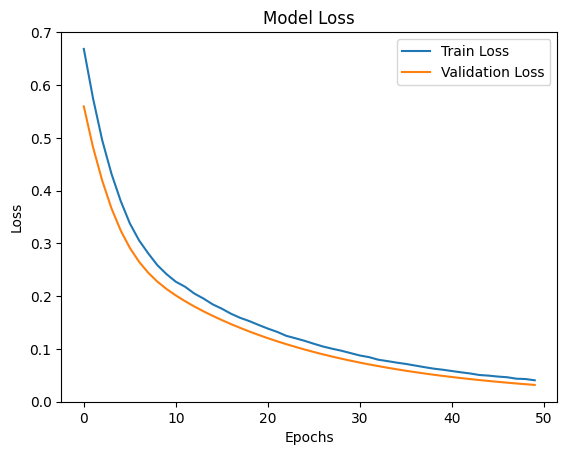

In [8]:
# Implement early stopping to halt training if validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping callback
history = model.fit(train_X_reshaped, train_y_clean, epochs=50, batch_size=32, validation_data=(val_X_reshaped, val_y_clean),
                    verbose=1, callbacks=[early_stopping])

# Save the model to a file (in HDF5 format)
model.save('/content/lstm_model_cleaned.h5')

# Print message indicating model is saved
print("Model saved as 'lstm_model_cleaned.h5'")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/lstm_model_cleaned.h5')

# Check if the model was loaded correctly
print(f"Model loaded successfully.")


Model loaded successfully.


In [10]:
# Load the scaled feature data (from 25th to 29th March)
val_X_scaled = pd.read_csv('/content/val_X_scaled.csv', index_col='date_time')

# Print the first few rows of the features to ensure they are correct
print(val_X_scaled.head())


                         hour    minute  day_of_week  is_weekend  \
date_time                                                          
2025-03-25 00:00:00  0.000000  0.000000     0.166667         0.0   
2025-03-25 00:15:00  0.000000  0.333333     0.166667         0.0   
2025-03-25 00:30:00  0.000000  0.666667     0.166667         0.0   
2025-03-25 00:45:00  0.000000  1.000000     0.166667         0.0   
2025-03-25 01:00:00  0.043478  0.000000     0.166667         0.0   

                     day_progress  day_sine  day_cosine     lag_1     lag_2  \
date_time                                                                     
2025-03-25 00:00:00      0.000000   0.50000    1.000000  0.211212  0.226401   
2025-03-25 00:15:00      0.010526   0.50000    1.000000  0.192992  0.211212   
2025-03-25 00:30:00      0.021053   0.50000    1.000000  0.228720  0.192992   
2025-03-25 00:45:00      0.031579   0.50000    1.000000  0.219099  0.228720   
2025-03-25 01:00:00      0.042105   0.62941    0.

In [11]:
# Reshape the data to the expected shape for LSTM input (samples, time steps, features)
val_X_reshaped = val_X_scaled.values.reshape((val_X_scaled.shape[0], 1, val_X_scaled.shape[1]))

# Check the shape of the reshaped data
print(f"Shape of reshaped validation data: {val_X_reshaped.shape}")


Shape of reshaped validation data: (480, 1, 14)


In [12]:
# Make predictions on the scaled validation data (March 25th to 29th)
predictions_scaled = model.predict(val_X_reshaped)

# Rescale the predictions back to the original scale (load)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Save the predictions to a CSV file
predictions_df = pd.DataFrame(predictions, columns=['predicted_load'], index=val_X_scaled.index)
predictions_df.to_csv('/content/future_predictions_25_to_29_March.csv')

# Print the first few rows of the predictions
print(predictions_df.head())


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
                     predicted_load
date_time                          
2025-03-25 00:00:00    11527.042969
2025-03-25 00:15:00    11547.385742
2025-03-25 00:30:00    11609.381836
2025-03-25 00:45:00    11699.164062
2025-03-25 01:00:00    11501.999023


In [13]:
import os

# Directory to save predictions
output_dir = '/content/predictions'
os.makedirs(output_dir, exist_ok=True)

# Ensure that the index is a DatetimeIndex
predictions_df.index = pd.to_datetime(predictions_df.index)

# Iterate through each date (from 25th to 29th March) and save predictions
for date in pd.date_range('2025-03-25', '2025-03-29'):
    # Filter predictions for the specific date
    date_str = date.strftime('%Y-%m-%d')

    # Filter based on the date, by extracting the date part from the index
    date_predictions = predictions_df[predictions_df.index.date == date.date()]

    # Save the filtered predictions to a separate file
    file_path = os.path.join(output_dir, f'predictions_{date_str}.csv')
    date_predictions.to_csv(file_path)

    # Print message for each file saved
    print(f"Saved predictions for {date_str} to {file_path}")


Saved predictions for 2025-03-25 to /content/predictions/predictions_2025-03-25.csv
Saved predictions for 2025-03-26 to /content/predictions/predictions_2025-03-26.csv
Saved predictions for 2025-03-27 to /content/predictions/predictions_2025-03-27.csv
Saved predictions for 2025-03-28 to /content/predictions/predictions_2025-03-28.csv
Saved predictions for 2025-03-29 to /content/predictions/predictions_2025-03-29.csv


In [15]:
import pandas as pd

# File paths for the actual data (March 25th to March 29th)
actual_files = [
    '/content/2025-03-25.csv',
    '/content/2025-03-26.csv',
    '/content/2025-03-27.csv',
    '/content/2025-03-28.csv',
    '/content/2025-03-29.csv'
]

# Dictionary to store actual data
actual_data = {}

# Load the actual data
for file in actual_files:
    df = pd.read_csv(file, index_col='date_time')
    df['date_time'] = pd.to_datetime(df.index)
    actual_data[file] = df

# File paths for the predicted data (from the predictions folder)
predicted_files = [
    '/content/predictions/predictions_2025-03-25.csv',
    '/content/predictions/predictions_2025-03-26.csv',
    '/content/predictions/predictions_2025-03-27.csv',
    '/content/predictions/predictions_2025-03-28.csv',
    '/content/predictions/predictions_2025-03-29.csv'
]

# Dictionary to store predicted data
predictions_data = {}

# Load the predicted data
for file in predicted_files:
    df = pd.read_csv(file, index_col='date_time')
    df['date_time'] = pd.to_datetime(df.index)
    predictions_data[file] = df

# Check the loaded actual and predicted data (for one date)
print(actual_data['/content/2025-03-25.csv'].head())
print(predictions_data['/content/predictions/predictions_2025-03-25.csv'].head())


                             load           date_time
date_time                                            
2025-03-25 00:00:00  11593.240430 2025-03-25 00:00:00
2025-03-25 00:15:00  11763.879753 2025-03-25 00:15:00
2025-03-25 00:30:00  11712.731055 2025-03-25 00:30:00
2025-03-25 00:45:00  11627.883008 2025-03-25 00:45:00
2025-03-25 01:00:00  11364.352018 2025-03-25 01:00:00
                     predicted_load           date_time
date_time                                              
2025-03-25 00:00:00       11527.043 2025-03-25 00:00:00
2025-03-25 00:15:00       11547.386 2025-03-25 00:15:00
2025-03-25 00:30:00       11609.382 2025-03-25 00:30:00
2025-03-25 00:45:00       11699.164 2025-03-25 00:45:00
2025-03-25 01:00:00       11501.999 2025-03-25 01:00:00


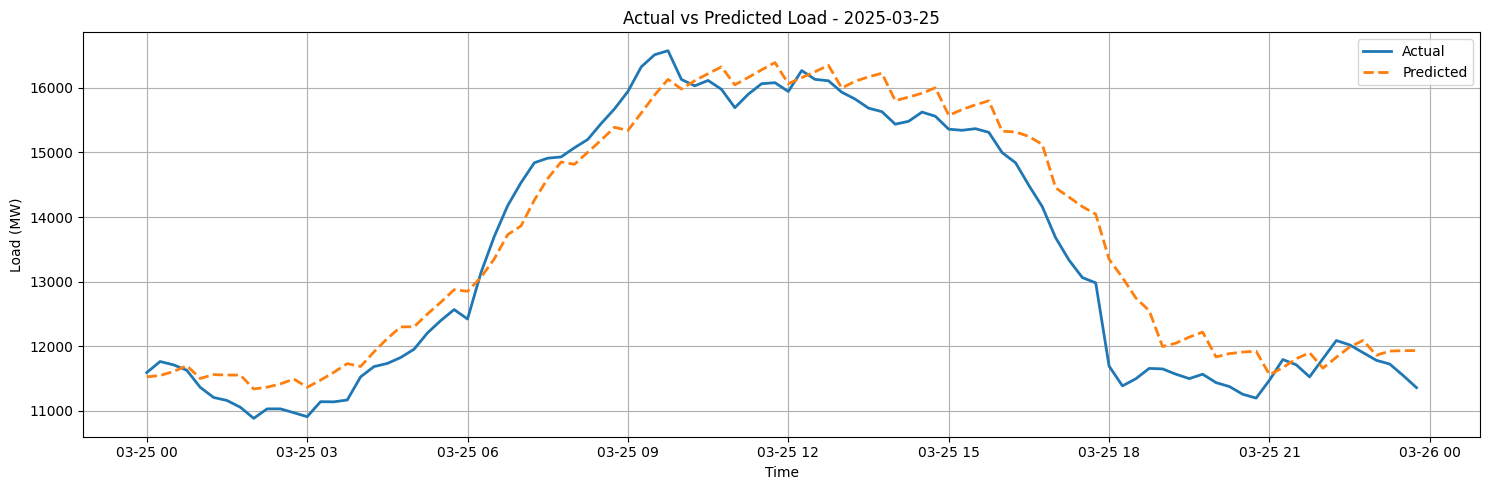

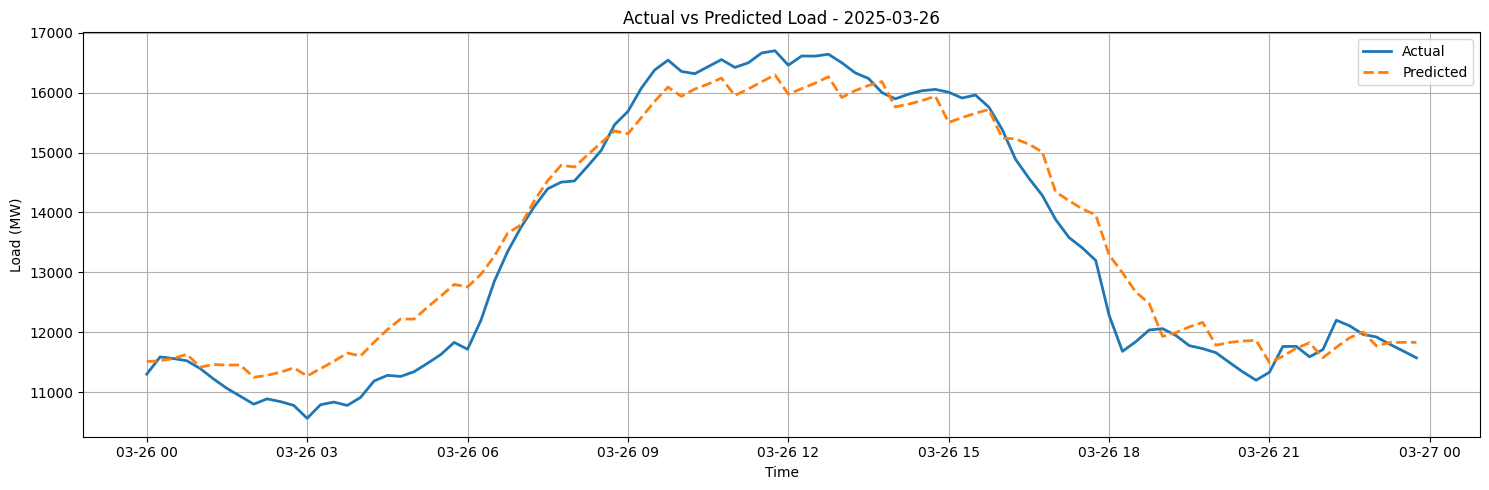

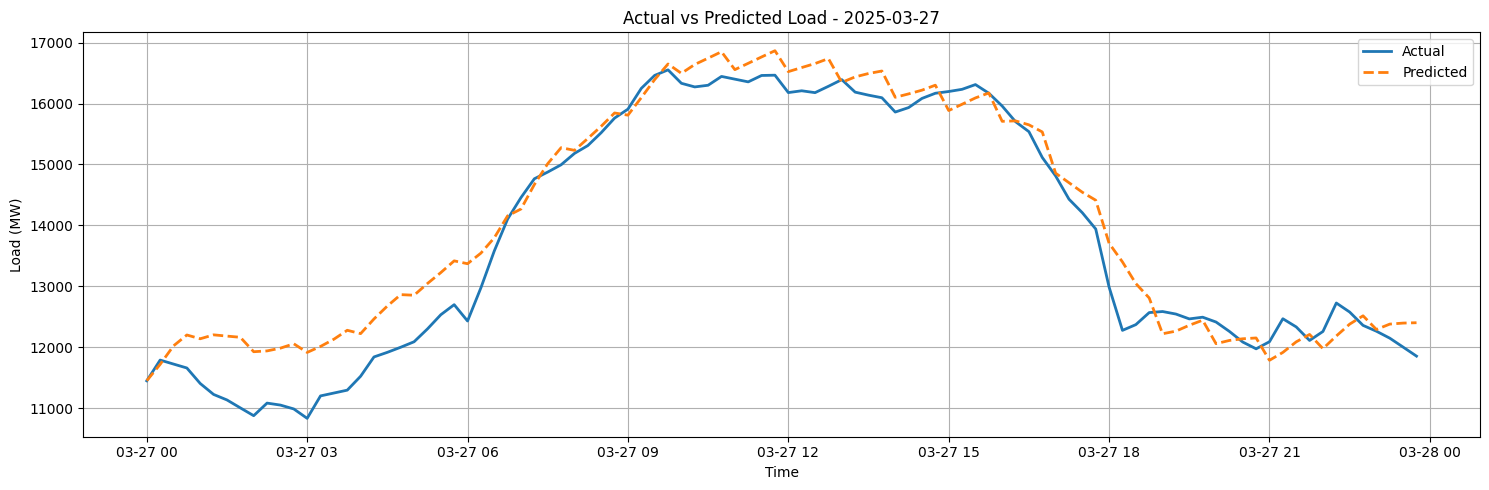

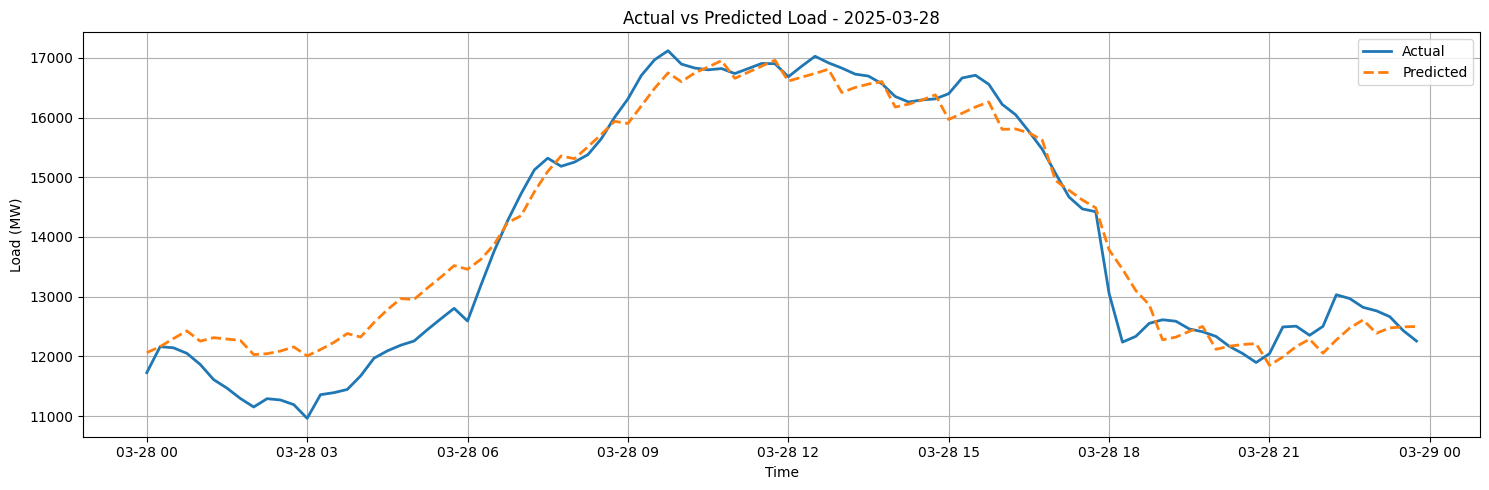

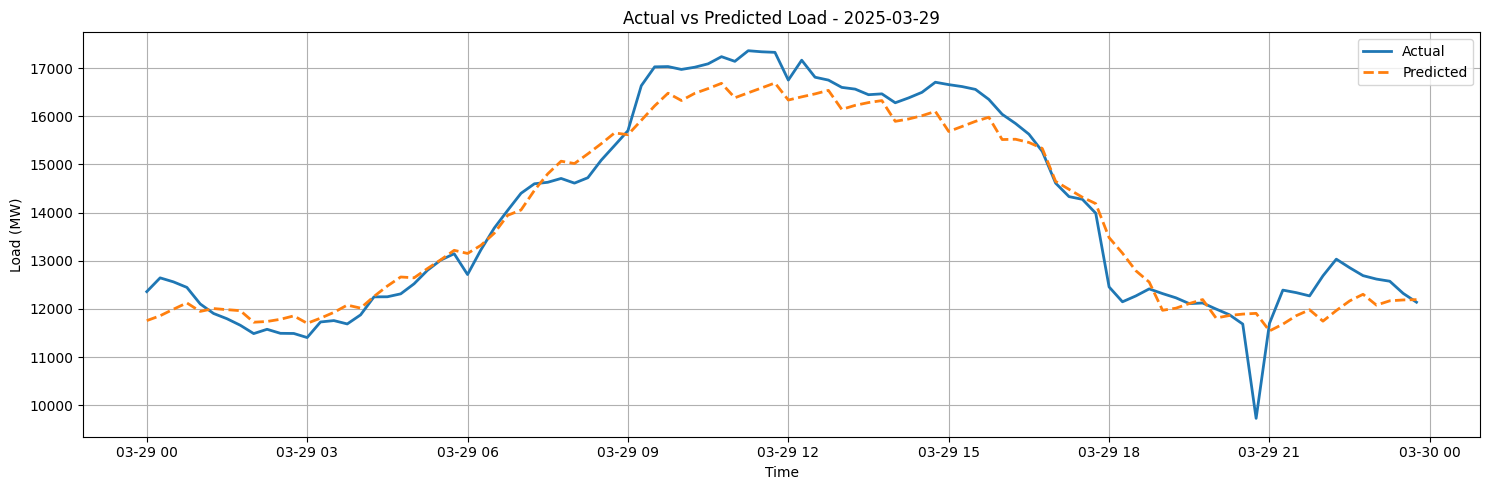

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Iterate through each date to plot actual vs predicted load
for date_str in ['2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28', '2025-03-29']:
    # Load the actual data for the current day
    actual_df = actual_data[f'/content/{date_str}.csv']

    # Load the predicted data for the current day
    predicted_df = predictions_data[f'/content/predictions/predictions_{date_str}.csv']

    # Get the actual and predicted values
    actual = actual_df['load']
    predicted = predicted_df['predicted_load']

    # Get the time labels (date_time column)
    time_labels = pd.to_datetime(actual_df['date_time'])

    # Plot actual vs predicted
    plt.figure(figsize=(15, 5))
    plt.plot(time_labels, actual, label='Actual', linewidth=2)
    plt.plot(time_labels, predicted, label='Predicted', linestyle='--', linewidth=2)
    plt.title(f"Actual vs Predicted Load - {date_str}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize lists to store the metrics for each day
mae_list = []
rmse_list = []
mape_list = []
dates = []

# Iterate through each date to calculate the metrics
for date_str in ['2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28', '2025-03-29']:
    # Load the actual and predicted data for the current day
    actual_df = actual_data[f'/content/{date_str}.csv']
    predicted_df = predictions_data[f'/content/predictions/predictions_{date_str}.csv']

    # Calculate the metrics (MAE, RMSE, MAPE)
    mae = mean_absolute_error(actual_df['load'], predicted_df['predicted_load'])
    rmse = np.sqrt(mean_squared_error(actual_df['load'], predicted_df['predicted_load']))
    mape = np.mean(np.abs((actual_df['load'] - predicted_df['predicted_load']) / actual_df['load'])) * 100

    # Append the metrics to the respective lists
    mae_list.append(mae)
    rmse_list.append(rmse)
    mape_list.append(mape)
    dates.append(date_str)

# Print the metrics for each day
print("Metrics per day:")
for i, date_str in enumerate(dates):
    print(f"{date_str} - MAE: {mae_list[i]}, RMSE: {rmse_list[i]}, MAPE: {mape_list[i]}")


Metrics per day:
2025-03-25 - MAE: 413.64567572699576, RMSE: 515.4546991626538, MAPE: 3.211396990520029
2025-03-26 - MAE: 406.91079367405, RMSE: 495.11436559239587, MAPE: 3.198416063940058
2025-03-27 - MAE: 398.2431438971624, RMSE: 507.06332336655134, MAPE: 3.1556756230177943
2025-03-28 - MAE: 364.0923394198926, RMSE: 470.44787937024853, MAPE: 2.833853534247971
2025-03-29 - MAE: 391.07002954101534, RMSE: 508.05872664294355, MAPE: 2.8178152541502377


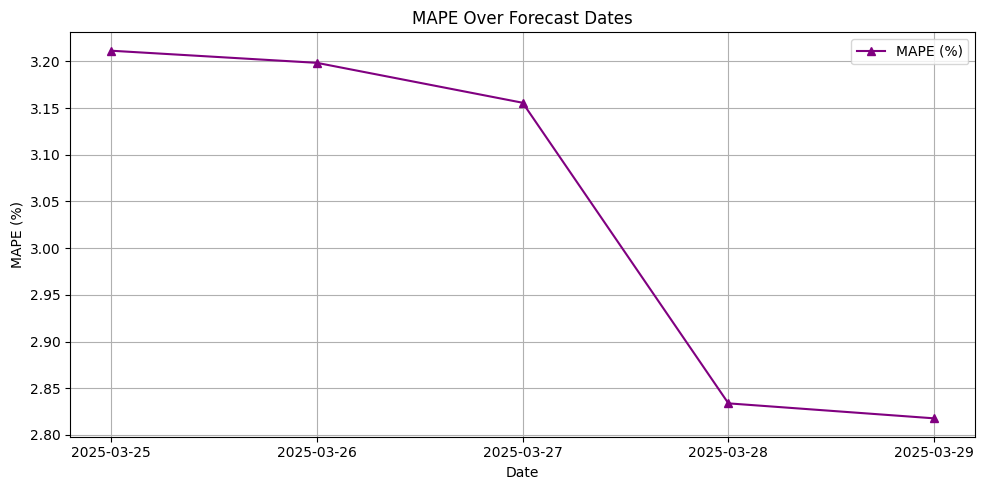

In [19]:
# Plot MAPE over forecast dates using the provided characteristics
plt.figure(figsize=(10, 5))
plt.plot(dates, mape_list, marker='^', color='purple', label='MAPE (%)')
plt.title("MAPE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


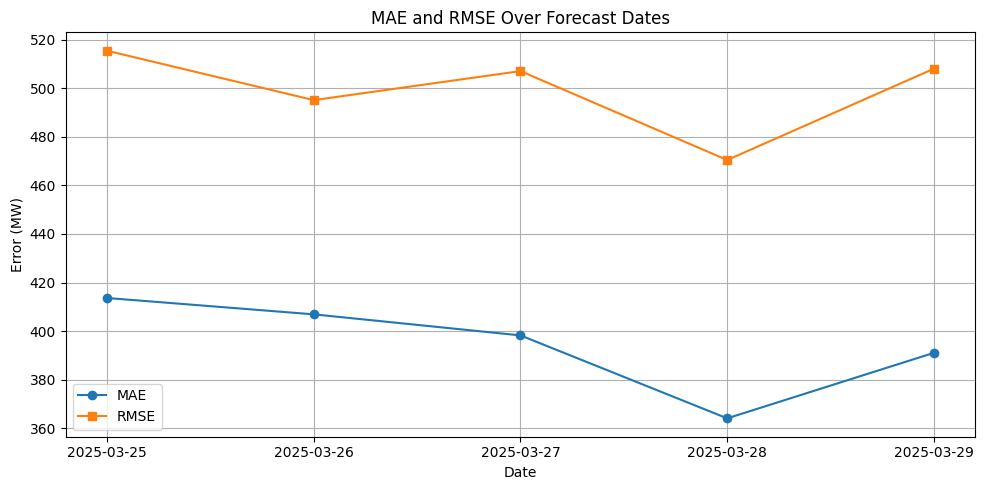

In [20]:
# Plot MAE and RMSE over forecast dates using the provided characteristics
plt.figure(figsize=(10, 5))
plt.plot(dates, mae_list, marker='o', label='MAE')
plt.plot(dates, rmse_list, marker='s', label='RMSE')
plt.title("MAE and RMSE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
